In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from perfectswish.image_transformation.image_processing import transform_board

In [77]:
def remove_green(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of green color in HSV
    lower_green = np.array([35, 0, 0])
    upper_green = np.array([90, 255, 255])
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    # copy the original image
    res = img.copy()
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(res, res, mask=mask)
    return res

In [78]:
def show_im(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

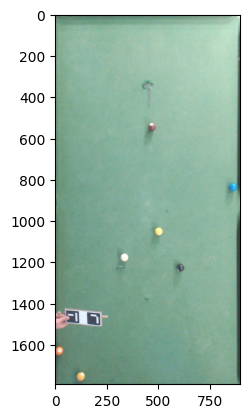

In [79]:
cap = cv2.VideoCapture('detect_objects_test_images/fiducials_2.mp4')
rect = [(36, 931), (60, 79), (1754, 108), (1735, 970)]

# show the first frame
ret, frame = cap.read()
cropped_frame = transform_board(frame, rect)
show_im(cropped_frame)

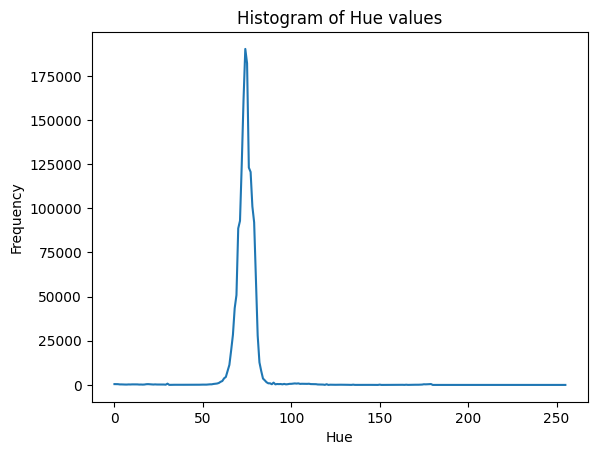

In [80]:
# calculate the histogram of the cropped frame to find the green color
hsv = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2HSV)
hist = cv2.calcHist([hsv], [0], None, [256], [0, 256])
plt.plot(hist)

# add axis labels
plt.xlabel('Hue')
plt.ylabel('Frequency')
plt.title('Histogram of Hue values')

plt.show()

74


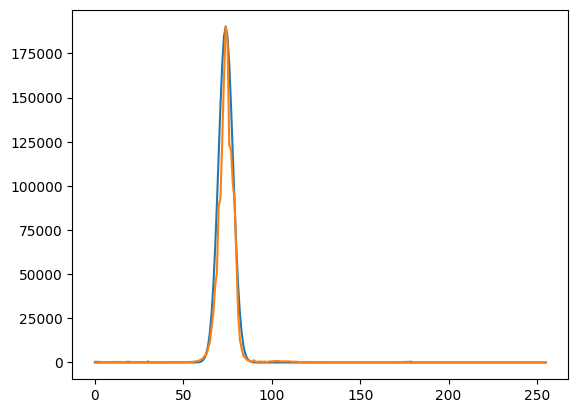

In [81]:
# find the peak of the histogram
max_value = np.max(hist)
max_index = np.argmax(hist)
print(max_index)


# fit a gaussian to the histogram by hand
def gaussian(x, a, b, c):
    return a * np.exp(-b * (x - c) ** 2)


x = np.linspace(0, 255, 256)
plt.plot(x, gaussian(x, max_value, 0.03, max_index))
plt.plot(hist)
plt.show()


def fitted_gaussian_normed(x):
    return np.exp(-0.03 * (x - max_index) ** 2)

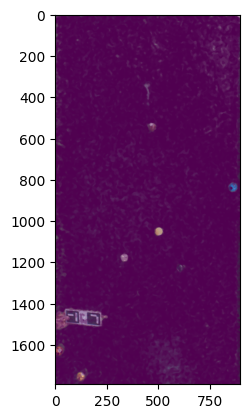

In [118]:
# now set the set each pixel to black if it is close of the peak

def expanded_gaussian_normed(x, gauss_center=max_index, gauss_width=0.001):
    return np.exp(-gauss_width * (x - gauss_center) ** 2)


def better_remove_green(img, gauss_center=max_index, gauss_width=0.001):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = expanded_gaussian_normed(hsv[:, :, 0], gauss_center, gauss_width)
    # make the masks dimensions the same as the image
    mask = np.expand_dims(mask, axis=2)
    mask = np.repeat(mask, 3, axis=2)
    # one minus the mask to get the inverse
    mask = 1 - mask
    # normalize the mask
    mask = (mask * 255 / np.max(mask)).astype(np.uint8)
    # apply median filter to the mask a bunch of times
    for i in range(10):
        mask = cv2.medianBlur(mask.astype(np.uint8), 5)
    
    unnormed_mask = mask / 255
    # copy the original image
    res = img.copy()
    COLOR = np.array([80, 0, 80])
    res = (unnormed_mask * res + (1-unnormed_mask) * COLOR).astype(np.uint8)
    return res


# show the result
first_attempt = better_remove_green(cropped_frame)
show_im(first_attempt)

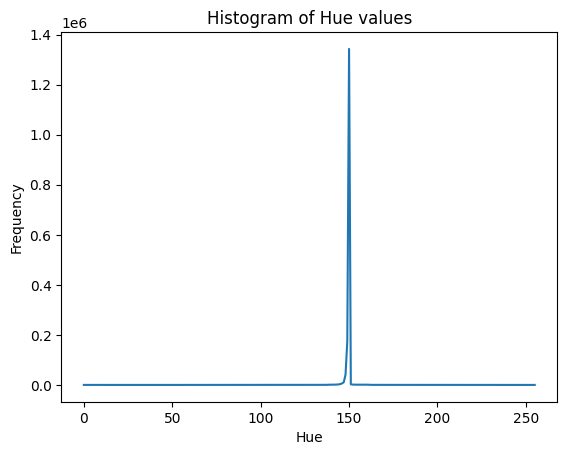

In [119]:
# calculate the histogram of the first attempt
hsv = cv2.cvtColor(first_attempt, cv2.COLOR_BGR2HSV)
hist = cv2.calcHist([hsv], [0], None, [256], [0, 256])
plt.plot(hist)
# add axis labels
plt.xlabel('Hue')
plt.ylabel('Frequency')
plt.title('Histogram of Hue values')
plt.show()


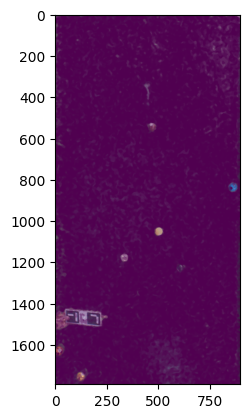

In [120]:
rmove_high = better_remove_green(first_attempt, 90, 0.3)
rmove_low = better_remove_green(rmove_high, 60, 0.3)
show_im(rmove_low)


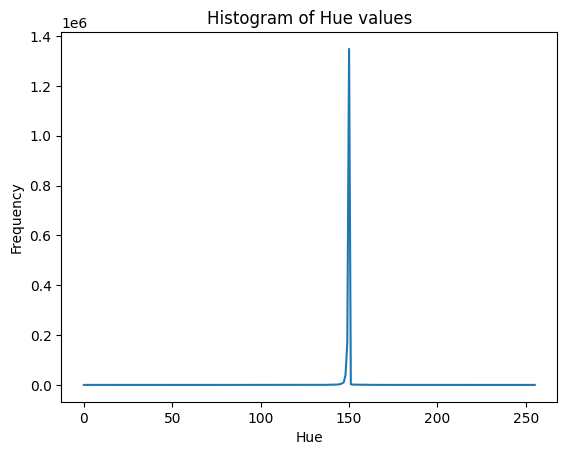

In [121]:
# calculate the histogram of the second attempt
hist = cv2.calcHist([cv2.cvtColor(rmove_low, cv2.COLOR_BGR2HSV)], [0], None, [256], [0, 256])
plt.plot(hist)
# add axis labels
plt.xlabel('Hue')
plt.ylabel('Frequency')
plt.title('Histogram of Hue values')
plt.show()


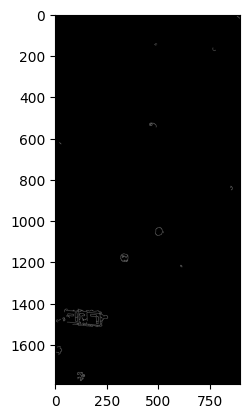

In [122]:
# lets try canny edge detection and hough circles to find the circles
# apply canny edge detection
gray = cv2.cvtColor(rmove_low, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)
show_im(edges)
    

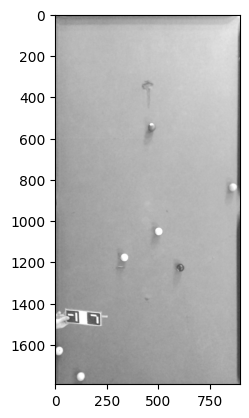

In [126]:
cropped_frame = transform_board(frame, rect)
hsv_cropped = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2HSV)
show_im(hsv_cropped[:,:, 2])